In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt
from obspy.imaging.beachball import beach
import bs4 as bs
import matplotlib as mpl

def calc_b_with_time_window(dataframe, n_eq, time_window_center):
    df_window = dataframe.copy()
    time_window_index = df_window.index.get_loc(time_window_center, method='pad')
    
    lower_index = time_window_index - n_eq
    if lower_index < 0:
        lower_index = 0
    
#     df_window = df_window.ix[time_window_index - n_eq : time_window_index + n_eq]
    df_window = df_window.ix[lower_index : time_window_index + n_eq]
    a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_window.mag)
    return a, b, bstd, n, mc, time_window_index

def calc_b_value_for_parameters(dataframe, parameters, location):
    # TODO: will multiprocessing speed this up?
    rows = []
    for r, t in parameters:
        try:
#             for r, t in parameters:
            df_c = polygon_selection.get_node_data(node=location, data=dataframe, radius=r, m=1)
            df_c = df_c.loc[df_c.index >= t]

            a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_c.mag)
            row = np.array((r,) + (t,) + (a, b, bstd, n, mc) + tuple(location))
            rows.append(row)
        except:
            row = np.array((r,) + (t,) +(np.nan, np.nan, np.nan, np.nan, np.nan) + tuple(location))

    return rows

def calc_b_for_parameters_attr_iter(attr):
    dataframe, parameters, location = attr
    return calc_b_value_for_parameters(dataframe, parameters, location)

def plot_beach_ball(earthquake, m, ax, **kwargs):
    lon, lat = earthquake['coordinates']
    x, y = m(lon, lat)
    b = beach(earthquake['focal_mech'], xy=(x, y), **kwargs)
    b.set_zorder(10)
    ax.add_collection(b)
    
def parse_coords(c):
    c = c.replace('\t', '')
    c = c.replace('\n', '')
    c = c.strip()
    c = c.split(' ')
    c = [[float(co) for co in coord.split(',')] for coord in c]
    c = np.array([np.array(co) for co in c])
    return c

In [2]:
df = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])
kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00', 'tz':'UTC', 'magnitude':7.0, 'name':'Kumamoto', 'focal_mech':[128  , 71 , -14]}
eq = kumamoto

df_regional = polygon_selection.get_node_data(data=df, node=eq['coordinates'], radius=75, m=1)
df_regional = df_regional.loc[df_regional.index < eq['time']]
df_regional = df_regional[df_regional.depth <=25]
df_regional = df_regional[df_regional.mag >= 0.5]

soup = bs.BeautifulSoup(open('/home/max/research/kumamoto/data/kyushu_fault.kml'), 'lxml')
fault_coordinates = [parse_coords(tag.text) for tag in soup.findAll('coordinates')]

In [142]:
df_regional.describe()

lon           lat  decimal_year         month           day  \
count  51284.000000  51284.000000  51284.000000  51284.000000  51284.000000   
mean     130.719734     32.830673   2006.025576      6.528917     15.624815   
std        0.310519      0.301235      6.163820      3.391969      8.747028   
min      129.961667     32.083000   1990.007888      1.000000      1.000000   
25%      130.522667     32.630000   2000.955371      4.000000      8.000000   
50%      130.739167     32.881000   2006.352809      6.000000     15.000000   
75%      130.918333     33.046667   2011.347743      9.000000     23.000000   
max      131.563333     33.429000   2016.285374     12.000000     31.000000   

                mag         depth          hour        minute        second  \
count  51284.000000  51284.000000  51284.000000  51284.000000  5.128400e+04   
mean       0.999380      9.857137     11.525252     29.589131  3.005194e+01   
std        0.522494      2.939647      6.848089     17.293879  1.738019e+01   
min        0.500000      0.000000      0.000000      0.000000  4.116446e-07   
25%        0.600000      8.170000      6.000000     15.000000  1.497000e+01   
50%        0.800000     10.190000     12.000000     30.000000  3.013000e+01   
75%        1.200000     11.740000     17.000000     45.000000  4.506250e+01   
max        5.000000     25.000000     23.000000     59.000000  6.000000e+01   

       horizontal_error   depth_error  mag_err      distance  
count      51284.000000  50036.000000      0.0  51284.000000  
mean           0.423676      0.858871      NaN     40.786949  
std            0.463147      0.621465      NaN     19.702006  
min            0.024214      0.020000      NaN      0.275102  
25%            0.239703      0.520000      NaN     24.814872  
50%            0.298955      0.650000      NaN     42.067751  
75%            0.401162      0.930000      NaN     56.879878  
max           13.337924      5.000000      NaN     74.998733

# regional seismicity

In [3]:
df[df.lon.between(130, 131) & df.lat.between(32, 33) & (df.mag > 6)]

lon        lat  decimal_year  month   day  \
timestamp                                                                      
2016-04-14 12:26:34.429989  130.808667  32.741667   2016.285570    4.0  14.0   
2016-04-14 15:03:46.450011  130.777667  32.700667   2016.285868    4.0  14.0   
2016-04-15 16:25:05.470004  130.763000  32.754500   2016.288754    4.0  15.0   

                            mag  depth  hour  minute     second  \
timestamp                                                         
2016-04-14 12:26:34.429989  6.5  11.39  12.0    26.0  34.430003   
2016-04-14 15:03:46.450011  6.4   6.71  15.0     3.0  46.449997   
2016-04-15 16:25:05.470004  7.3  12.45  16.0    25.0   5.469997   

                            horizontal_error  depth_error  mag_err  
timestamp                                                           
2016-04-14 12:26:34.429989          0.369826         0.90      NaN  
2016-04-14 15:03:46.450011          0.501366         1.64      NaN  
2016-04-15 16:25:05.470004          0.405566         0.84      NaN

In [4]:
foreshock1 = {'focal_mech':[299, 79, -10], 'magnitude':6.5, 'coordinates':[130.808667, 32.741667]}
foreshock2 = {'focal_mech':[30, 77, 180], 'magnitude':6.4, 'coordinates':(130.777667, 32.700667)}

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=130.31303194773173,32.30453194773171,131.21296805226828,33.20446805226829&bboxSR=4269&imageSR=4269&size=1500,1500&dpi=96&format=png32&f=image


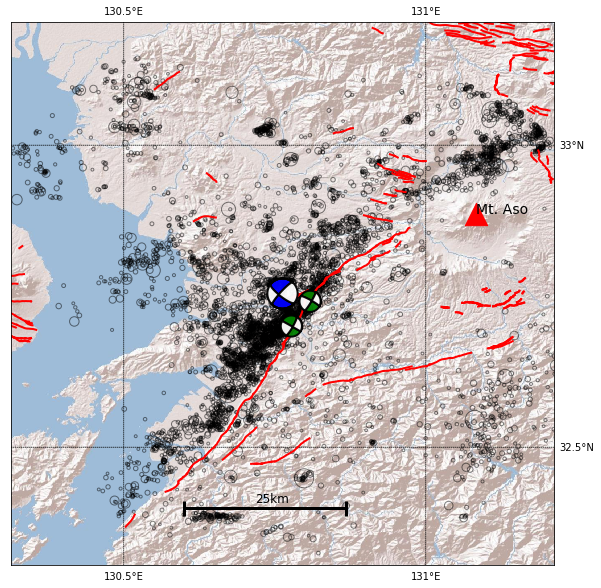

In [5]:
plt.close()
eq = kumamoto

data = polygon_selection.get_node_data(node=eq['coordinates'], data=df, radius=500, m=1)
data = data.loc[data.index <= eq['time']]

fig, ax = plt.subplots(1, figsize=(10, 10))


lon, lat = eq['coordinates']

dist_in_deg = 50./111.119

m = Basemap(projection='merc'
            ,llcrnrlon=lon-dist_in_deg
            ,llcrnrlat=lat-dist_in_deg
            ,urcrnrlon=lon+dist_in_deg
            ,urcrnrlat=lat+dist_in_deg
            , epsg=4269
            , ax=ax
            , resolution='i'
            , area_thresh=1)

# m.drawcoastlines()
lines = np.arange(0, 180, 0.5)
m.drawparallels(lines, labels=lines)
m.drawmeridians(lines, labels=lines)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True
             ,zorder=0)

#### DATA USED FOR CALCULATIONS
data2 = polygon_selection.get_node_data(node=eq['coordinates'], data=df, radius=50, m=1)

lons = data2[data2.mag >= 2]['lon'].values
lats = data2[data2.mag >= 2]['lat'].values

x, y = m(lons, lats)

ax.scatter(x, y, s=np.exp(data[data.mag>=2].mag.values), zorder=2, edgecolors='black'
           ,color='None', alpha=0.5, rasterized=True)
#### DATA OUTSIDE OF SELECTION PERIMETER

# lons = data[data.mag >= 2]['lon'].values
# lats = data[data.mag >= 2]['lat'].values

# x, y = m(lons, lats)

# ax.scatter(x, y, s=np.exp(data[data.mag>=2].mag.values), zorder=1, color='black', alpha=0.13)

plot_beach_ball(earthquake=eq, m=m, ax=ax, width=0.05, alpha=0.95)
plot_beach_ball(earthquake=foreshock1, m=m, ax=ax, width=0.035, alpha=0.95, facecolor='green')
plot_beach_ball(earthquake=foreshock2, m=m, ax=ax, width=0.035, alpha=0.95, facecolor='green')
# ax.set_title(eq['name'], fontsize=60, y=0.9)


# PLOT FAULT LINES
for fault in fault_coordinates:
    x, y = m(fault[:,0], fault[:,1])
    ax.plot(x, y, color='red', linewidth=2)
    
x, y = m(131.0841, 32.8869)
ax.text(s='Mt. Aso', x=x, y=y, fontsize=14, zorder=5)

# x, y = m(131.0841, 32.8869)
ax.scatter(x, y, marker='^', s=500, color='red')

# m.drawmapscale(131.5, 32.4, eq['coordinates'][0], eq['coordinates'][1], 25)

lat_km = 111.119
lon_km = (111.19 * np.cos(np.deg2rad(eq['coordinates'][1])))

x, y = m([130.6, 130.6 + 25./lon_km], [32.4, 32.4])

ax.plot(x, y, linestyle='-', marker='|', markersize=15, color='black', linewidth=3
       ,markeredgewidth=3)
x, y = m(130.6 + 11./lon_km, 32.41)
ax.text(s='25km', x=x, y=y, fontsize=12)

fig.savefig('paper_plots/regional_seismicity_zoom.pdf', bbox_inches='tight', dpi=300)

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=128.763,30.754500000000004,132.763,34.7545&bboxSR=4269&imageSR=4269&size=1500,1500&dpi=96&format=png32&f=image


{32.7545: ([<matplotlib.lines.Line2D at 0x7f600c4f9550>],
   <matplotlib.text.Text at 0x7f600c4c6e80>]),
 33.20446805226829: ([<matplotlib.lines.Line2D at 0x7f600c50c5f8>],
   <matplotlib.text.Text at 0x7f600c4b5588>]),
 33.654436104536579: ([<matplotlib.lines.Line2D at 0x7f600c50cf98>],
   <matplotlib.text.Text at 0x7f600c4b5c50>]),
 34.104404156804868: ([<matplotlib.lines.Line2D at 0x7f600c516978>],
   <matplotlib.text.Text at 0x7f600c4d2358>]),
 34.554372209073158: ([<matplotlib.lines.Line2D at 0x7f600c51e358>],
   <matplotlib.text.Text at 0x7f600c4d2a20>])}

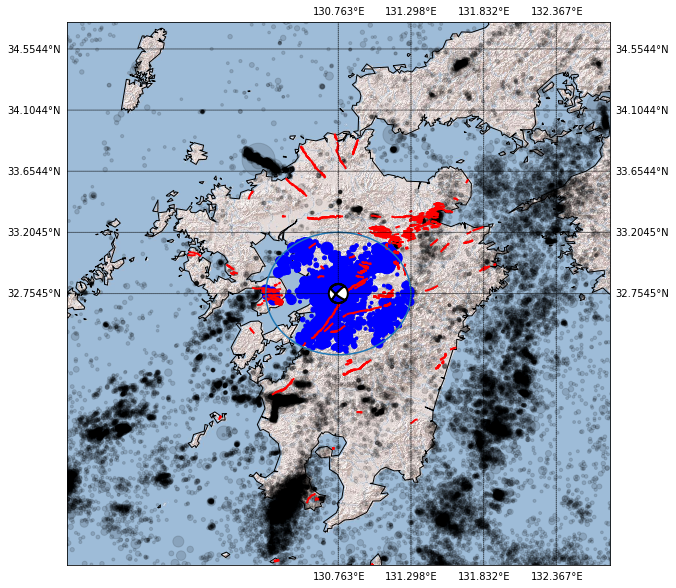

In [6]:
eq = kumamoto

data = polygon_selection.get_node_data(node=eq['coordinates'], data=df, radius=500, m=1)
data = data.loc[data.index <= eq['time']]

fig, ax = plt.subplots(1, figsize=(10,10))


lon, lat = eq['coordinates']


m = Basemap(llcrnrlon=lon-2
            ,llcrnrlat=lat-2
            ,urcrnrlon=lon+2
            ,urcrnrlat=lat+2
            , epsg=4269
            , ax=ax
            , resolution='i'
            , area_thresh=1)

m.drawcoastlines()
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True
             ,zorder=0)

#### DATA USED FOR CALCULATIONS
data2 = polygon_selection.get_node_data(node=eq['coordinates'], data=df, radius=50, m=1)

lons = data2[data2.mag >= 2]['lon'].values
lats = data2[data2.mag >= 2]['lat'].values

x, y = m(lons, lats)

ax.scatter(x, y, s=np.exp(data[data.mag>=2].mag.values), zorder=2, color='blue', rasterized=True)

#### DATA OUTSIDE OF SELECTION PERIMETER

lons = data[data.mag >= 2]['lon'].values
lats = data[data.mag >= 2]['lat'].values

x, y = m(lons, lats)

ax.scatter(x, y, s=np.exp(data[data.mag>=2].mag.values), zorder=1, color='black'
           , alpha=0.13, rasterized=True)

plot_beach_ball(earthquake=eq, m=m, ax=ax, width=eq['magnitude']/50.)
# ax.set_title(eq['name'], fontsize=60, y=0.9)

# PLOT FAULT LINES
for fault in fault_coordinates:
    x, y = m(fault[:,0], fault[:,1])
    ax.plot(x, y, color='red', linewidth=2)

plotting.equi(m, eq['coordinates'][0], eq['coordinates'][1], 50)    


lat_km = 50./111.119
lon_km = 50./(111.19 * np.cos(np.deg2rad(eq['coordinates'][1])))


lons = np.arange(eq['coordinates'][0], 180,lon_km)
m.drawmeridians(lons, labels=lons)
lats = np.arange(eq['coordinates'][1], 180, lat_km)
m.drawparallels(lats, labels=lats)



# fig.savefig('paper_plots/regional_seismicity.pdf', bbox_inches='tight')


http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=130.31303194773173,32.30453194773171,131.21296805226828,33.20446805226829&bboxSR=4269&imageSR=4269&size=1500,1500&dpi=96&format=png32&f=image


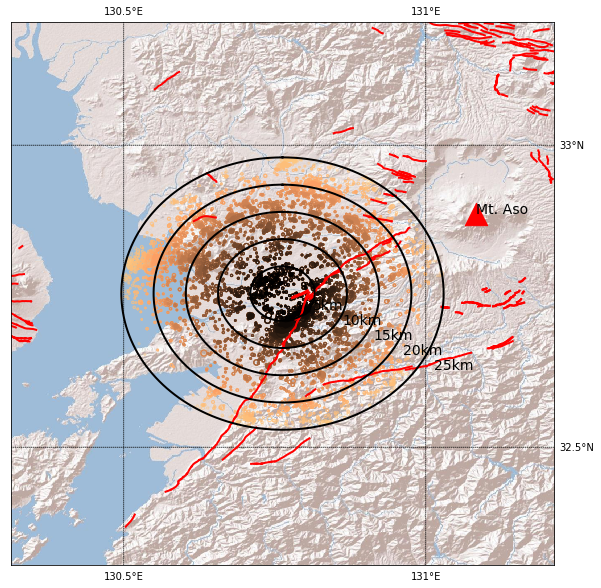

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
norm = mpl.colors.Normalize(vmin=5, vmax=25)


dist_in_deg = 50./111.119

m = Basemap(projection='merc'
            ,llcrnrlon=lon-dist_in_deg
            ,llcrnrlat=lat-dist_in_deg
            ,urcrnrlon=lon+dist_in_deg
            ,urcrnrlat=lat+dist_in_deg
            , epsg=4269
            , ax=ax
            , resolution='i'
            , area_thresh=1)

lines = np.arange(0, 180, 0.5)
m.drawparallels(lines, labels=lines)
m.drawmeridians(lines, labels=lines)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True
             ,zorder=0)


# PLOT FAULT LINES
for fault in fault_coordinates:
    x, y = m(fault[:,0], fault[:,1])
    ax.plot(x, y, color='red', linewidth=2)

r = 5
for r in np.arange(5, 26, 1)[::-1]:
    eqs = polygon_selection.get_node_data(node=eq['coordinates'],data=df_regional
                                          , radius=r, m=1)
    eqs = eqs[eqs.mag >= 1]

    x, y = m(eqs['lon'].values, eqs['lat'].values)

    ax.scatter(x, y, edgecolors=mpl.cm.copper(norm(r)), alpha=0.5, color='None'
              ,s=np.exp(eqs['mag'].values), rasterized=True)
    
x, y = m(131.0841, 32.8869)
ax.text(s='Mt. Aso', x=x, y=y, fontsize=14, zorder=5)

# x, y = m(131.0841, 32.8869)
ax.scatter(x, y, marker='^', s=500, color='red')

x, y = m(eq['coordinates'][0], eq['coordinates'][1])
# ax.scatter(x, y, s=np.exp(7.3), edgecolors='yellow', color='None', linewidth=3)
# ax.text(s='M7.3', x=x+.05, y=y, color='yellow', fontsize=20, zorder=5)
# plot_beach_ball(earthquake=eq, m=m, ax=ax, width=0.05, alpha=0.95)

r = 5
for r in np.arange(5, 26, 5):
    plotting.equi(m, eq['coordinates'][0], eq['coordinates'][1]
                  , r, color='black', linewidth=2)
    ax.text(s='{r}km'.format(r=r), x=x+(r)/100., y=y-(r*0.5)/100., fontsize=14
           ,color='black')

# fig.savefig('paper_plots/b_over_t_seismicity.pdf', bbox_inches='tight')

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=130.31303194773173,32.30453194773171,131.71296805226828,33.70446805226829&bboxSR=4269&imageSR=4269&size=1500,1500&dpi=96&format=png32&f=image


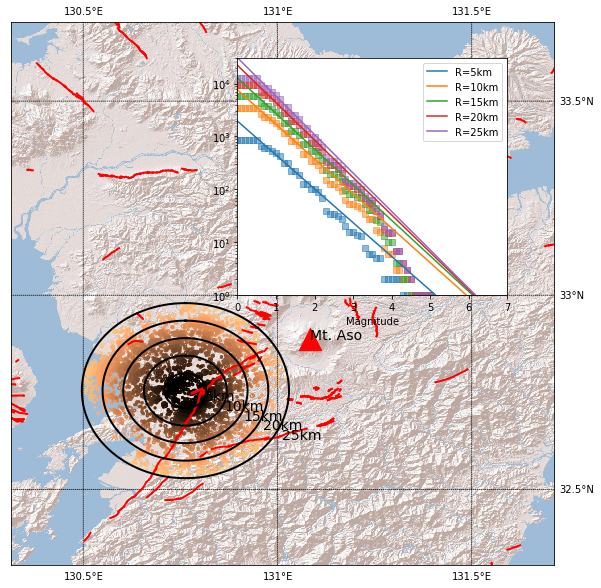

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
norm = mpl.colors.Normalize(vmin=5, vmax=25)


dist_in_deg = 50./111.119

m = Basemap(projection='merc'
            ,llcrnrlon=lon-dist_in_deg
            ,llcrnrlat=lat-dist_in_deg
            ,urcrnrlon=lon+dist_in_deg + 0.5
            ,urcrnrlat=lat+dist_in_deg + 0.5
            , epsg=4269
            , ax=ax
            , resolution='i'
            , area_thresh=1)

lines = np.arange(0, 180, 0.5)
m.drawparallels(lines, labels=lines)
m.drawmeridians(lines, labels=lines)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True
             ,zorder=0)


# PLOT FAULT LINES
for fault in fault_coordinates:
    x, y = m(fault[:,0], fault[:,1])
    ax.plot(x, y, color='red', linewidth=2)

r = 5
for r in np.arange(5, 26, 1)[::-1]:
    eqs = polygon_selection.get_node_data(node=eq['coordinates'],data=df_regional
                                          , radius=r, m=1)
    eqs = eqs[eqs.mag >= 1]

    x, y = m(eqs['lon'].values, eqs['lat'].values)

    ax.scatter(x, y, edgecolors=mpl.cm.copper(norm(r)), alpha=0.5, color='None'
              ,s=np.exp(eqs['mag'].values), rasterized=True)
    
x, y = m(131.0841, 32.8869)
ax.text(s='Mt. Aso', x=x, y=y, fontsize=14, zorder=5)

# x, y = m(131.0841, 32.8869)
ax.scatter(x, y, marker='^', s=500, color='red')

x, y = m(eq['coordinates'][0], eq['coordinates'][1])
# ax.scatter(x, y, s=np.exp(7.3), edgecolors='yellow', color='None', linewidth=3)
# ax.text(s='M7.3', x=x+.05, y=y, color='yellow', fontsize=20, zorder=5)
# plot_beach_ball(earthquake=eq, m=m, ax=ax, width=0.05, alpha=0.95)

r = 5
for r in np.arange(5, 26, 5):
    plotting.equi(m, eq['coordinates'][0], eq['coordinates'][1]
                  , r, color='black', linewidth=2)
    ax.text(s='{r}km'.format(r=r), x=x+(r)/100., y=y-(r*0.5)/100., fontsize=14
           ,color='black')

# t [left, bottom, width, height]     
ax2 = fig.add_axes([0.45, 0.5, 0.375, 0.33])
for r in np.arange(5, 26, 5):
    eqs = polygon_selection.get_node_data(node=eq['coordinates'],data=df_regional
                                          , radius=r, m=1)
    h, e = np.histogram(a=eqs.mag, bins=100, range=(0, 10))
    chist = np.cumsum(h[::-1])[::-1]
    
    a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(eqs.mag)
    ax2.scatter(e[:-1], chist, marker='s', alpha=0.5, label=None)
    
    x = np.arange(0, 10, 0.1)
    y = 10**(a - b * x)
    ax2.plot(x, y, label='R={r}km'.format(r=r))
    
ax2.set_yscale('log')
ax2.set_ylim(1e0, 10**a)
ax2.set_xlim(0, 7)
ax2.set_xlabel('Magnitude')
ax2.legend()
fig.savefig('paper_plots/b_over_t_seismicity_with_gr.pdf', bbox_inches='tight')

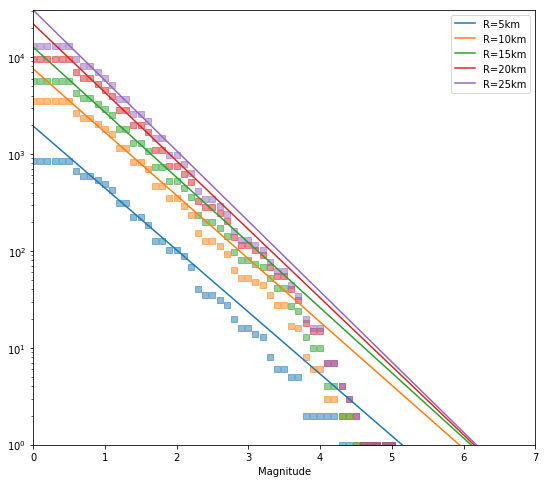

In [15]:
fig, ax = plt.subplots(figsize=(9, 8))

for r in np.arange(5, 26, 5):
    eqs = polygon_selection.get_node_data(node=eq['coordinates'],data=df_regional
                                          , radius=r, m=1)
    h, e = np.histogram(a=eqs.mag, bins=100, range=(0, 10))
    chist = np.cumsum(h[::-1])[::-1]
    
    a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(eqs.mag)
    ax.scatter(e[:-1], chist, marker='s', alpha=0.5, label=None)
    
    x = np.arange(0, 10, 0.1)
    y = 10**(a - b * x)
    ax.plot(x, y, label='R={r}km'.format(r=r))
    
ax.set_yscale('log')
ax.set_ylim(1e0, 10**a)
ax.set_xlim(0, 7)
ax.set_xlabel('Magnitude')

ax.legend()

# FMDs EVERYWHERE

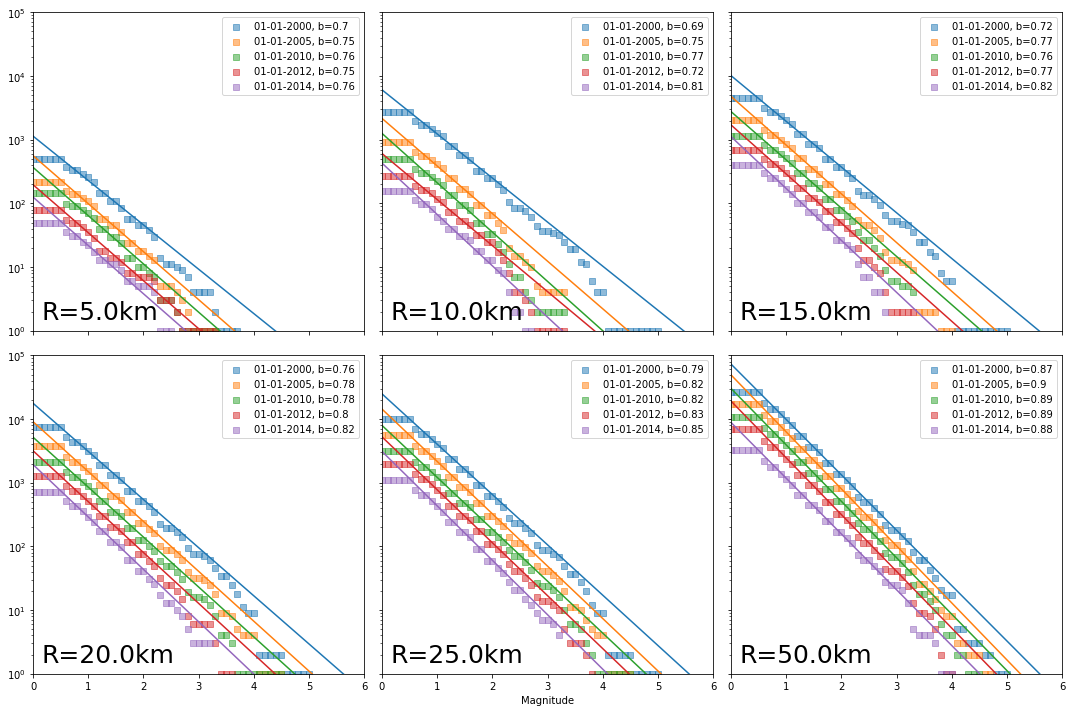

In [16]:
# radius 5
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)

# [item for sublist in l for item in sublist]

ax = [x for sublist in ax for x in sublist]

radii = [5., 10., 15., 20., 25., 50.]
time = ['01-01-2000', '01-01-2005', '01-01-2010', '01-01-2012', '01-01-2014']

# t = time[0]
# for axis in ax:
for axis, r in zip(ax, radii):
#     print(r)
    for t in time:
        df_hist = df_regional[df_regional.distance <= r]
        df_hist = df_hist.loc[df_hist.index >= t]
        hist, edges = np.histogram(a=df_hist.mag.values, bins=100, range=(0, 10))
        chist = np.cumsum(hist[::-1])[::-1]


        a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_hist.mag)

        axis.scatter(edges[:-1], chist, marker='s', label='{t}, b={b}'.format(t=t, b=round(b, 2))
              ,alpha=0.5)

        x = np.arange(0, 6, 0.01)
        y = 10**(a - b * x)
        axis.plot(x, y)
#     axis.set_title('radius={r}km'.format(r=r))

    axis.set_yscale('log')
    axis.set_ylim(1e0, 1e5)
    axis.set_xlim(0, 6)
    axis.legend()
    
    axis.text(s='R={r}km'.format(r=r), x=0.15, y=1.5e0, fontsize=25)

ax[4].set_xlabel('Magnitude')
plt.tight_layout()

fig.savefig('paper_plots/GR_plots.pdf', bbox_inches='tight')

# PARAMETER SWEEP PLOT

* ADD - bootstrapped contours to plots
* REMOVE - NON-bootstrapped errors from plots

In [17]:
radii = np.arange(5, 26, 1)
foreshock_time = eq['time']

timii = pd.date_range(start='01-01-1990 00:00:00', end=foreshock_time, freq='6M', tz='GMT')
parameters = [x for x in product(radii, timii)]

In [143]:
len(parameters)

1113

In [121]:
fmds = calc_b_value_for_parameters(df_regional, parameters, eq['coordinates'])

bdf = pd.DataFrame(fmds, columns=['radius', 'start_time', 'a', 'b', 'bstd', 'n', 'mc', 'lon', 'lat'])


In [138]:
bdf.head()

radius                start_time         a         b      bstd    n   mc  \
0       5 1990-01-31 00:00:00+00:00  3.288952  0.639406  0.022519  599  0.8   
1       5 1990-07-31 00:00:00+00:00  3.288817  0.641963  0.022729  596  0.8   
2       5 1991-01-31 00:00:00+00:00  3.288837  0.644728  0.022977  593  0.8   
3       5 1991-07-31 00:00:00+00:00  3.288981  0.645823  0.023068  592  0.8   
4       5 1992-01-31 00:00:00+00:00  3.288981  0.645823  0.023068  592  0.8   

       lon      lat  
0  130.763  32.7545  
1  130.763  32.7545  
2  130.763  32.7545  
3  130.763  32.7545  
4  130.763  32.7545

In [123]:
bdf.to_csv('data/bdf_6_14_2017.csv', index=False)

In [18]:
bdf = pd.read_csv('data/bdf_6_14_2017.csv')

In [19]:
t = pd.to_datetime('01-01-2001')
r = 5
def get_booted_errored_df(df, r, t):
    df_boot = df.copy()
    df_boot = df_boot.loc[df_boot.index >= t]
    df_boot = stats.get_catalog_shifted_by_location_normal_error(df_boot)
    df_boot = polygon_selection.get_node_data(node=eq['coordinates'], data=df_boot, radius=5, m=1)
    df_boot.loc[np.random.choice(df_boot.index, size=(1, df.shape[0]))[0]]
    return df_boot

get_booted_errored_df(df_regional, r, t).shape

(366, 15)

In [20]:
t = pd.to_datetime('01-01-2001')
r = 5
df_boot = get_booted_errored_df(df_regional, r, t)
stats.calc_fmd_stats_with_mc(df_boot.mag)

(2.9315049802596023,
 0.72900014651430212,
 0.043587697303939126,
 223,
 0.80000000000000004)

In [14]:
def calc_booted_errored_fmd(params):
    df, r, t = params
    
    df_boot = get_booted_errored_df(df, r, t)
    return stats.calc_fmd_stats_with_mc(df.mag)

iterations=5
for n in range(iterations):
    print(calc_booted_errored_fmd([df_regional, r, t]))

(5.1183645886580758, 0.80248069873377936, 0.0040086248623299381, 36027, 0.69999999999999996)
(5.1183645886580758, 0.80248069873377936, 0.0040086248623299381, 36027, 0.69999999999999996)
(5.1183645886580758, 0.80248069873377936, 0.0040086248623299381, 36027, 0.69999999999999996)
(5.1183645886580758, 0.80248069873377936, 0.0040086248623299381, 36027, 0.69999999999999996)
(5.1183645886580758, 0.80248069873377936, 0.0040086248623299381, 36027, 0.69999999999999996)


In [15]:
data = pool.map([get_booted_errored_df,)

SyntaxError: invalid syntax (<ipython-input-15-97dd0a9c5b8e>, line 1)

In [ ]:
from multiprocessing import Pool
pool = Pool()

results = pool.map(calc_booted_errored_fmd, everything)

In [ ]:
def calc_b_value_for_parameters(dataframe, parameters, location):
    rows = []
    for r, t in parameters:
        try:
            df_c = stats.get_catalog_shifted_by_location_normal_error(dataframe)
            df_c = polygon_selection.get_node_data(node=location, data=dataframe, radius=r, m=1)
            df_c = df_c.loc[df_c.index >= t]

            a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_c.mag)
            row = np.array((r,) + (t,) + (a, b, bstd, n, mc) + tuple(location))
            rows.append(row)
        except:
            row = np.array((r,) + (t,) +(np.nan, np.nan, np.nan, np.nan, np.nan) + tuple(location))
    
    return rows

def calc_b_for_parameters_attr_iter(attr):
    dataframe, parameters, location = attr
    return calc_b_value_for_parameters(dataframe, parameters, location)

from multiprocessing import Pool
pool = Pool()

results = pool.map(calc_b_for_parameters_attr_iter, everything)

In [ ]:
def calculate_b_value_parameter_sweep(dataframe, location, n_iterations, parameters):
    """
    calculates grid search data for fmd statistics
    """
    # TODO: this is probably too specific for here
    rows = []
    for r, t in parameters:
        raw_df = dataframe.loc[dataframe.index >= t].copy()
        raw_df = polygon_selection.get_node_data(data=raw_df, radius=r, node=location, m=1)

        try:
            b = calc_bootstrapped_fmd_values(get_catalog_shifted_by_location_normal_error(raw_df)
                                                   , n_iterations)
            bdf = pd.DataFrame(np.array(b), columns=['a', 'b', 'bstd', 'n', 'mc'])
            row = [(r,), (t,), bdf.mean().values, bdf.std().values]
            row = np.concatenate(np.array(row))

        except ValueError:
            row = (r,) + (t,) + (np.nan,) * 10

        rows.append(row)

    bdf = pd.DataFrame(rows, columns=['radius', 'start_time', 'a_avg', 'b_avg', 'bstd_avg', 'n_avg', 'mc_avg'
        , 'a_std', 'b_std', 'bstd_std', 'n_std', 'mc_std'])
    bdf[['radius', 'a_avg', 'b_avg', 'bstd_avg', 'n_avg', 'mc_avg'
        , 'a_std', 'b_std', 'bstd_std', 'n_std', 'mc_std']] = bdf[['radius', 'a_avg'
        , 'b_avg', 'bstd_avg'
        , 'n_avg', 'mc_avg'
        , 'a_std', 'b_std'
        , 'bstd_std', 'n_std'
        , 'mc_std']].apply(pd.to_numeric)
    bdf['start_time'] = pd.to_datetime(bdf['start_time'])

    return bdf

(<matplotlib.figure.Figure at 0x7f600bb4f630>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6002046c18>)

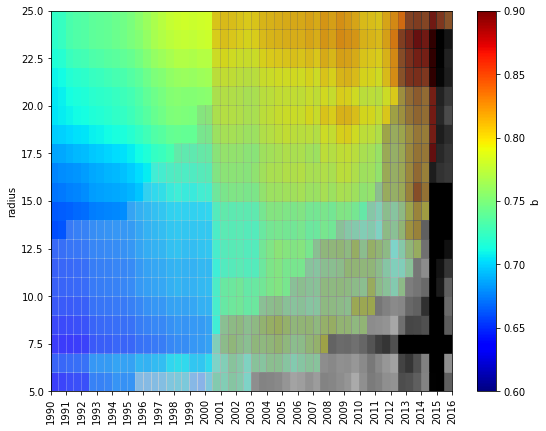

In [21]:
x = 0.025
bdf['b below {x}'.format(x=x)] = bdf.apply(lambda row: row['b'] if row['bstd'] > x else np.nan, axis=1)
x = 0.05
bdf['b below {x}'.format(x=x)] = bdf.apply(lambda row: row['b'] if row['bstd'] > x else np.nan, axis=1)
x = 0.01
bdf['b below {x}'.format(x=x)] = bdf.apply(lambda row: row['b'] if row['bstd'] > x else np.nan, axis=1)

fig, ax = plt.subplots(figsize=(9, 7))
plotting.plot_radius_time_sweep(bdf, 'radius', 'b', fig, ax, vmin=0.6, vmax=0.9, cmap='jet')
plotting.plot_radius_time_sweep(bdf, 'radius', 'b below 0.025', fig, ax, vmin=0.6, vmax=0.9, cmap='Greys', alpha=0.5, colorbar=False)
plotting.plot_radius_time_sweep(bdf, 'radius', 'b below 0.05', fig, ax, vmin=0.6, vmax=0.9, cmap='Greys', colorbar=False)
plotting.plot_radius_time_sweep(bdf, 'radius', 'b below 0.01', fig, ax, vmin=0.6, vmax=0.9, cmap='Greys', alpha=0.25, colorbar=False)

# fig.savefig('paper_plots/parameter_sweep.pdf', bbox_inches='tight')

In [108]:
data.describe()

radius          a          b       bstd            n         mc  \
count    53.0  53.000000  53.000000  53.000000    53.000000  53.000000   
mean     10.0   3.366388   0.732807   0.036571  1244.773585   0.711321   
std       0.0   0.519984   0.074765   0.056831  1013.513968   0.031988   
min      10.0   1.835065   0.652840   0.011121     9.000000   0.700000   
25%      10.0   3.088554   0.681598   0.012505   365.000000   0.700000   
50%      10.0   3.400535   0.738145   0.022621   768.000000   0.700000   
75%      10.0   3.856061   0.751802   0.033172  2393.000000   0.700000   
max      10.0   3.878263   1.101028   0.394616  2638.000000   0.800000   

                lon      lat  b below 0.025  b below 0.05  b below 0.01  
count  5.300000e+01  53.0000      22.000000      7.000000     53.000000  
mean   1.307630e+02  32.7545       0.787330      0.865678      0.732807  
std    5.738739e-14   0.0000       0.083062      0.115555      0.074765  
min    1.307630e+02  32.7545       0.728393      0.776787      0.652840  
25%    1.307630e+02  32.7545       0.747779      0.792099      0.681598  
50%    1.307630e+02  32.7545       0.756475      0.808808      0.738145  
75%    1.307630e+02  32.7545       0.783719      0.894464      0.751802  
max    1.307630e+02  32.7545       1.101028      1.101028      1.101028

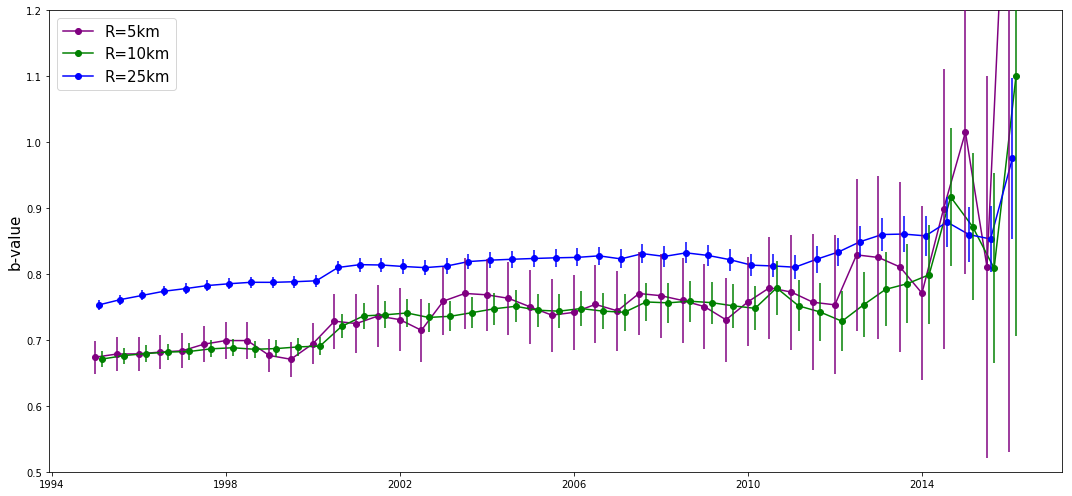

In [141]:
from datetime import timedelta
fig, ax = plt.subplots(figsize=(15,7))


data = bdf[(bdf.radius == 5)].copy()
data.start_time = pd.to_datetime(data.start_time)
data = data[data.start_time > '1995']
data.start_time = data.start_time - timedelta(days=30)
ax.plot_date(data.start_time, data.b, linestyle='-', label='R=5km', color='purple')
ax.errorbar(data.start_time.values, data.b, yerr=data.bstd, linestyle='', zorder=10, label=None, color='purple')

data = bdf[(bdf.radius == 10)].copy()
data.start_time = pd.to_datetime(data.start_time)
data = data[data.start_time > '1995']
data.start_time = data.start_time + timedelta(days=30)
ax.plot_date(data.start_time, data.b, linestyle='-', label='R=10km', color='green')
ax.errorbar(data.start_time.values, data.b, yerr=data.bstd, linestyle='', zorder=10, label=None, color='green')

data = bdf[(bdf.radius == 25)].copy()
data.start_time = pd.to_datetime(data.start_time)
data = data[data.start_time > '1995']
ax.plot_date(data.start_time, data.b, linestyle='-', label='R=25km', color='blue')
ax.errorbar(data.start_time.values, data.b, yerr=data.bstd, linestyle='', zorder=10, label=None, color='blue')


ax.set_ylabel('b-value', fontsize=15)
ax.set_ylim(0.5, 1.2)
ax.legend(fontsize=15)

plt.tight_layout()

fig.savefig('paper_plots/b_over_t_example.pdf', bbox_inches='tight')

# b-value scatter plots

* ADD - bootstrapped error to plots
* REMOVE - NON-bootstrapped error from plots

In [11]:
df_calc = df_regional.copy()

rows = []

for r, t in parameters:
    df_c = polygon_selection.get_node_data(node=eq['coordinates'], data=df_calc, radius=r, m=1)
    df_c = df_c.loc[df_c.index >= t]
    
    a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_c.mag)
    row = np.array((r,) + (t,) + (a, b, bstd, n, mc))
    rows.append(row)

true_bdf = pd.DataFrame(rows, columns=['radius', 'start_time', 'a', 'b', 'bstd', 'n', 'mc'])
true_bdf = true_bdf[true_bdf.n >= 50].copy()
true_bdf['years before'] = true_bdf['start_time'].values.astype('datetime64[Y]').astype(int) - 20

NameError: name 'parameters' is not defined

In [ ]:
true_bdf.to_csv('data/true_bdf_6_14_2017.csv', index=False)

In [23]:
true_bdf = pd.read_csv('data/true_bdf_6_14_2017.csv')

FileNotFoundError: File b'data/true_bdf_6_14_2017.csv' does not exist

In [24]:
true_bdf = bdf
true_bdf = true_bdf[true_bdf.n >= 50].copy()
true_bdf['years before'] = true_bdf['start_time'].values.astype('datetime64[Y]').astype(int) - 20

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  This is separate from the ipykernel package so we can avoid doing imports until


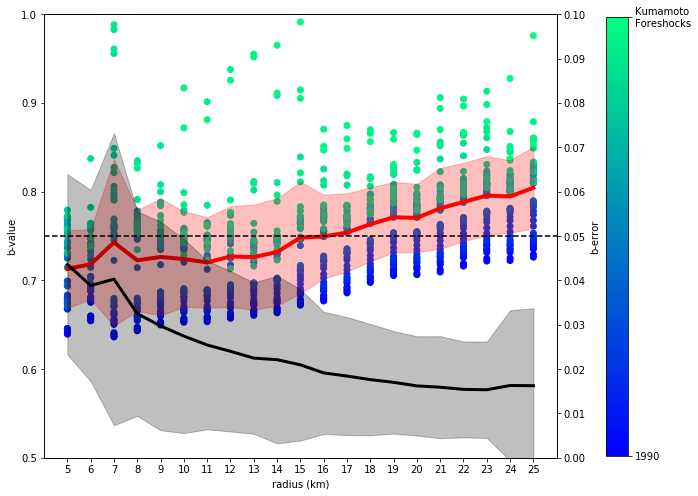

In [27]:
fig, ax = plt.subplots(figsize=(10, 7))

# time_ints = true_bdf['start_time'].astype('datetime64[Y, GMT]').astype(int)
time_ints = true_bdf['start_time'].astype('datetime64[ns]').astype(int)

cbar = ax.scatter(x=true_bdf['radius'], y=true_bdf['b']
                  , c=time_ints
                 ,cmap='winter')

cbar = fig.colorbar(cbar, ticks=[time_ints.min(), time_ints.max()], shrink=0.99, pad = 0.0751)
cbar.ax.set_yticklabels(['1990', 'Kumamoto\nForeshocks'])  # vertically oriented colorbar


x = np.arange(5, 26, 1)

ax.set_xticks(x)

avg = true_bdf.groupby('radius').b.mean()
std = true_bdf.groupby('radius').b.std()

ax.fill_between(x, avg-std, avg+std, alpha=0.25, color='red')
ax.plot(x, avg, color='red', linewidth=4)

ax.set_ylim(0.5, 1.0)
ax.set_ylabel('b-value')
ax.set_xlabel('radius (km)')

ax2 = ax.twinx()

ax2.plot(x, true_bdf.groupby('radius').bstd.mean(), color='black', linewidth=3)

avg =  true_bdf.groupby('radius').bstd.mean()
std =  true_bdf.groupby('radius').bstd.std()

ax2.fill_between(x, avg-std, avg+std, color='black', alpha=0.25)

ax2.set_ylim(0, 0.1)
x2 = np.arange(4, 27, 1)
ax2.plot(x2, (0.05,)*len(x2), linestyle='--', color='black')
ax2.set_xlim(4, 26)
ax2.set_ylabel('b-error')

ax2.set_yticks(np.arange(0, 0.11, 0.01))
plt.tight_layout()


fig.savefig('paper_plots/b_vs_r.pdf', bbox_inches='tight')

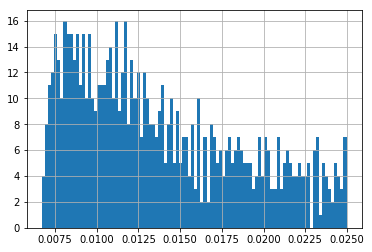

In [32]:
true_bdf[true_bdf.bstd <= 0.025].bstd.hist(bins=100)

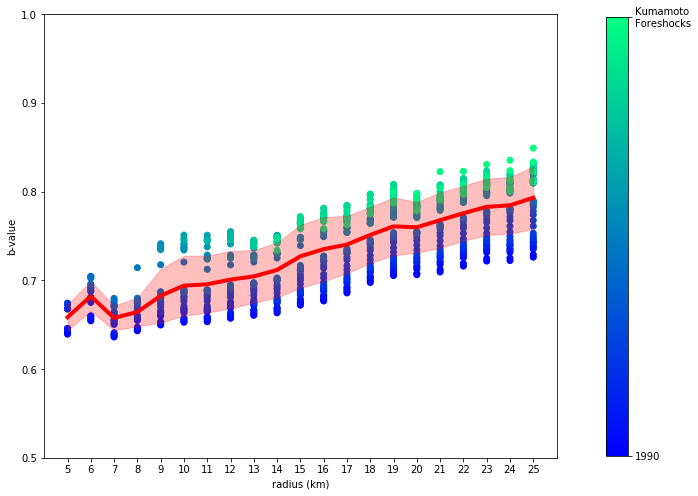

In [33]:
fig, ax = plt.subplots(figsize=(10, 7))

data = true_bdf[true_bdf.bstd <= 0.025].copy()

# time_ints = true_bdf['start_time'].astype('datetime64[Y, GMT]').astype(int)
time_ints = data['start_time'].astype('datetime64[ns]').astype(int)




cbar = ax.scatter(x=data['radius'], y=data['b']
                  , c=time_ints
                 ,cmap='winter')

cbar = fig.colorbar(cbar, ticks=[time_ints.min(), time_ints.max()], shrink=0.99, pad = 0.0751)
cbar.ax.set_yticklabels(['1990', 'Kumamoto\nForeshocks'])  # vertically oriented colorbar


x = np.arange(5, 26, 1)

ax.set_xticks(x)

avg = data.groupby('radius').b.mean()
std = data.groupby('radius').b.std()

ax.fill_between(x, avg-std, avg+std, alpha=0.25, color='red')
ax.plot(x, avg, color='red', linewidth=4)

ax.set_ylim(0.5, 1.0)
ax.set_ylabel('b-value')
ax.set_xlabel('radius (km)')

# ax2 = ax.twinx()

# ax2.plot(x, true_bdf.groupby('radius').bstd.mean(), color='black', linewidth=3)

# avg =  true_bdf.groupby('radius').bstd.mean()
# std =  true_bdf.groupby('radius').bstd.std()

# ax2.fill_between(x, avg-std, avg+std, color='black', alpha=0.25)

# ax2.set_ylim(0, 0.1)
# x2 = np.arange(4, 27, 1)
# ax2.plot(x2, (0.05,)*len(x2), linestyle='--', color='black')
# ax2.set_xlim(4, 26)
# ax2.set_ylabel('b-error')

# ax2.set_yticks(np.arange(0, 0.11, 0.01))
plt.tight_layout()


# fig.savefig('paper_plots/b_vs_r.pdf', bbox_inches='tight')

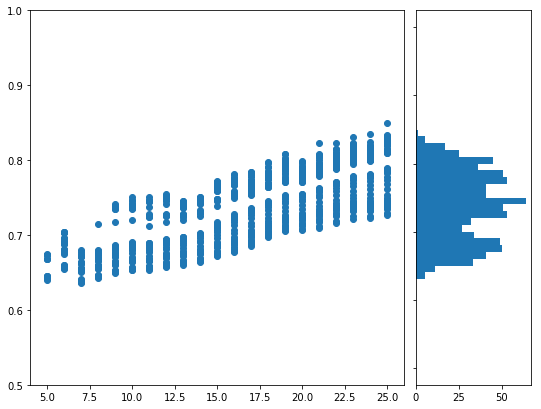

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

# the random data
# x = np.random.randn(1000)
# y = np.random.randn(1000)

x = data['radius'].values
y = data['b'].values

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8), )

axScatter = plt.axes(rect_scatter)
# axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
# axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, y)

# # now determine nice limits by hand:
# binwidth = 0.25
# xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
# lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim(4, 26)
axScatter.set_ylim(0.5, 1.0)

# bins = np.arange(-lim, lim + binwidth, binwidth)
# axHistx.hist(x, bins=bins)
# axHisty.hist(y, bins=bins, orientation='horizontal')

# hr, er = np.histogram(a=data['radius'], bins=20, range=(5, 25))
# hr = hr.astype(float)/true_bdf.shape[0]
# axHistx.plot(er[:-1], hr)
# data['radius'].hist(bins=20, range=(5, 25), ax=axHistx, normed=True, grid=False)
data['b'].hist(bins=np.arange(0.5, 1.01, 0.01), ax=axHisty, orientation='horizontal', grid=False)


axHistx.set_xlim(axScatter.get_xlim())
# axHisty.set_ylim(axScatter.get_ylim())

# plt.tight_layout()

ax.set_xlabel('radius')
ax.set_ylabel('b-value')

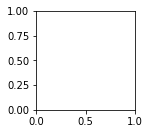

In [100]:
# subplot2grid(shape, loc, rowspan=1, colspan=1)

fig = plt.figure()
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=3)
ax1 = plt.subplot2grid((2, 3), (0, 1), colspan=1)
# ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
# ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)
# ax3 = plt.subplot2grid((3, 3), (1, 2), rowspan=2)
# ax4 = plt.subplot2grid((3, 3), (2, 0))
# ax5 = plt.subplot2grid((3, 3), (2, 1))

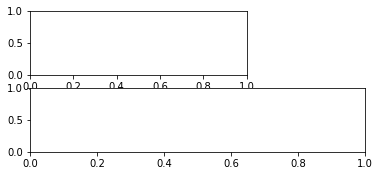

In [99]:
ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 1), (1, 2), rowspan=2)

In [58]:
true_bdf.groupby('radius').count()

start_time   a   b  bstd   n  mc  lon  lat  b below 0.025  \
radius                                                              
5               44  44  44    44  44  44   44   44             33   
6               46  46  46    46  46  46   46   46             25   
7               49  49  49    49  49  49   49   49             28   
8               49  49  49    49  49  49   49   49             27   
9               50  50  50    50  50  50   50   50             23   
10              51  51  51    51  51  51   51   51             20   
11              51  51  51    51  51  51   51   51             18   
12              51  51  51    51  51  51   51   51             17   
13              51  51  51    51  51  51   51   51             14   
14              52  52  52    52  52  52   52   52             11   
15              52  52  52    52  52  52   52   52             10   
16              52  52  52    52  52  52   52   52              9   
17              52  52  52    52  52  52   52   52              9   
18              52  52  52    52  52  52   52   52              9   
19              52  52  52    52  52  52   52   52              8   
20              52  52  52    52  52  52   52   52              7   
21              52  52  52    52  52  52   52   52              7   
22              52  52  52    52  52  52   52   52              7   
23              52  52  52    52  52  52   52   52              7   
24              53  53  53    53  53  53   53   53              7   
25              53  53  53    53  53  53   53   53              7   

        b below 0.05  b below 0.01  years before  
radius                                            
5                 18            44            44  
6                 11            46            46  
7                 13            49            49  
8                  8            49            49  
9                  8            50            50  
10                 5            51            51  
11                 4            51            51  
12                 3            51            51  
13                 3            49            51  
14                 3            42            52  
15                 3            40            52  
16                 3            39            52  
17                 2            36            52  
18                 2            33            52  
19                 2            33            52  
20                 2            31            52  
21                 2            31            52  
22                 2            31            52  
23                 2            31            52  
24                 1            32            53  
25                 2            32            53

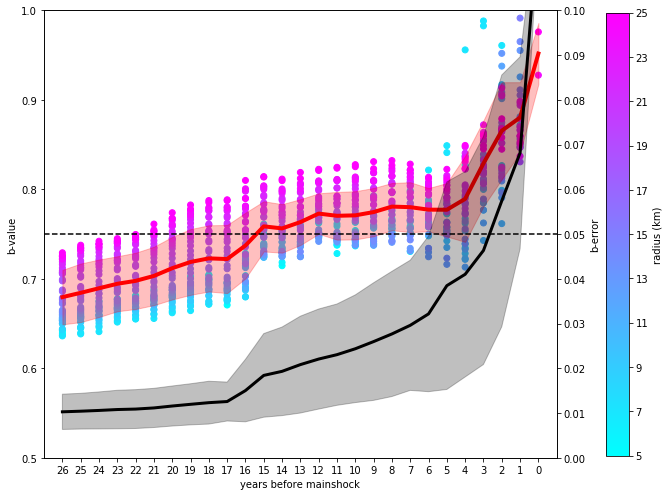

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))


cbar = ax.scatter(x=true_bdf['years before'], y=true_bdf['b']
                  , c=true_bdf['radius']
                 ,cmap='cool')

cbar = fig.colorbar(cbar, shrink=0.99, pad = 0.0751, label='radius (km)'
                   , ticks=[np.arange(5, 26, 2)])
cbar.ax.set_yticklabels(np.arange(5, 26, 2).astype(int))  # vertically oriented colorbar


x = np.arange(0, 27, 1)

ax.set_xticks(x)
ax.set_xticklabels(x[::-1])

avg = true_bdf.groupby('years before').b.mean()
std = true_bdf.groupby('years before').b.std()

ax.fill_between(x, avg-std, avg+std, alpha=0.25, color='red')
ax.plot(x, avg, color='red', linewidth=4)

ax.set_ylim(0.5, 1.0)
ax.set_ylabel('b-value')
ax.set_xlabel('years before mainshock')

ax2 = ax.twinx()

ax2.plot(x, true_bdf.groupby('years before').bstd.mean(), color='black', linewidth=3)

avg =  true_bdf.groupby('years before').bstd.mean()
std =  true_bdf.groupby('years before').bstd.std()

ax2.fill_between(x, avg-std, avg+std, color='black', alpha=0.25)
ax2.set_ylim(0, 0.1)
x2 = np.arange(-1, 28, 1)
ax2.plot(x2, (0.05,)*len(x2), linestyle='--', color='black')
ax2.set_xlim(-1, 27)
ax2.set_ylabel('b-error')

ax2.set_yticks(np.arange(0, 0.11, 0.01))
plt.tight_layout()


fig.savefig('paper_plots/b_vs_t.pdf', bbox_inches='tight')

# SLIDING TIME WINDOW

* ADD - radius 5km and radius 30km calculation to b over t
* ADD - radius 5km and 30km to FMD plots with same color
* ADD - legend to b over t
* ADD - legend to fmds

In [157]:
time_window_centers = pd.date_range('01-01-1991', eq['time'], freq='6m')

In [158]:
def calc_b_over_t_df(df, time_window_centers, half_window_size, radius):
    df = df[df.distance <= radius].copy()
    b_over_time = []
    
    for t in time_window_centers:
        row = (radius, t) + calc_b_with_time_window(df, n_eq=half_window_size*2, time_window_center=t)
        b_over_time.append(row)
        
    bdf = pd.DataFrame(b_over_time, columns=['radius', 'start_time', 'a', 'b', 'bstd', 'n', 'mc', 't_index'])
#     bdf = bdf.set_index(bdf['start_time'])
    return bdf

In [170]:
window_sizes = (50, 100, 250, 1000)
radii = np.arange(5, 31, 1)



/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


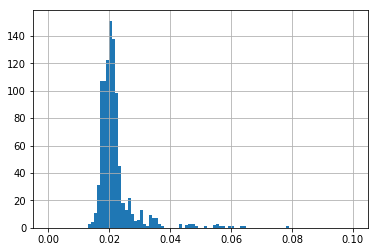

In [232]:
bt_df.bstd.hist(bins=100, range=(0,0.1
                                ))

In [288]:
def plot_window_b(window_size, value, fig, ax, cmap, vmin, vmax, colorbar=False):
    b_over_t = []
    for r in radii:
        b_over_t.append(calc_b_over_t_df(df=df_regional
                        , time_window_centers=time_window_centers
                         ,half_window_size=window_size, radius=r))
    bt_df = pd.concat(b_over_t)
    plotting.plot_radius_time_sweep(dataframe=bt_df, vertical_axis='radius'
                                    , value='b', fig=fig, ax=ax, cmap=cmap
                                   ,vmin=vmin, vmax=vmax, colorbar=colorbar)
    ax.text(s='$N_{EQ}=$'+'{n}'.format(n=window_size*2)
            , x=24, y=30.75, fontsize=21, color='black')
    
    return bt_df



/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/max/anaconda2/envs/research/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


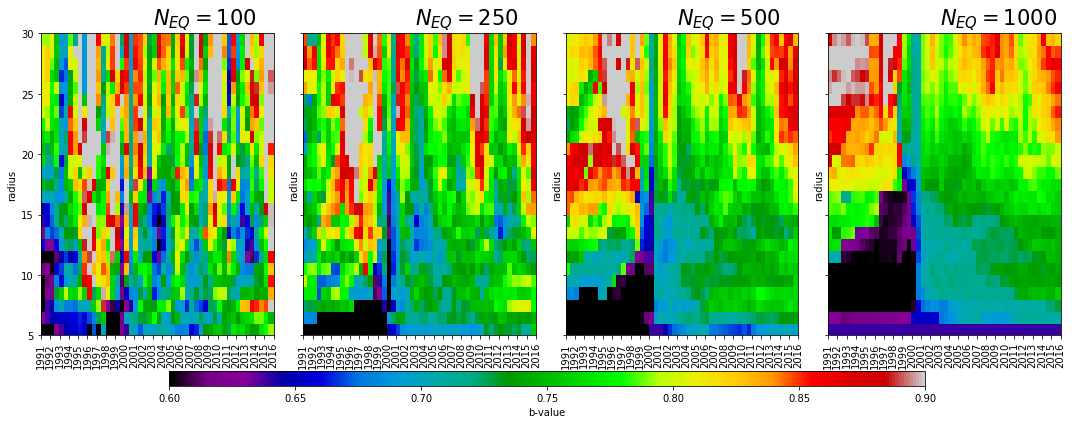

In [289]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5), sharey=True)
b50 = plot_window_b(window_size=50, value='b', fig=fig, ax=ax1, cmap='nipy_spectral', vmin=0.6, vmax=0.9)
b125 = plot_window_b(window_size=125, value='b', fig=fig, ax=ax2, cmap='nipy_spectral', vmin=0.6, vmax=0.9)
b250 = plot_window_b(window_size=250, value='b', fig=fig, ax=ax3, cmap='nipy_spectral', vmin=0.6, vmax=0.9)
b500 = plot_window_b(window_size=500, value='b', fig=fig, ax=ax4, cmap='nipy_spectral', vmin=0.6, vmax=0.9)
# plot_window_b(window_size=50, value='bstd', fig=fig, ax=ax1, cmap='gist_stern', vmin=0, vmax=0.1)
# plot_window_b(window_size=100, value='bstd', fig=fig, ax=ax2, cmap='gist_stern', vmin=0, vmax=0.1)
# plot_window_b(window_size=250, value='bstd', fig=fig, ax=ax3, cmap='gist_stern', vmin=0, vmax=0.1)
# plot_window_b(window_size=500, value='bstd', fig=fig, ax=ax4, cmap='gist_stern', vmin=0, vmax=0.1)

ax5 = fig.add_axes([0.16, -0.02, 0.7, .04])
cmap = mpl.cm.nipy_spectral
norm = mpl.colors.Normalize(vmin=0.6, vmax=0.9)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('b-value')


plt.tight_layout()


fig.savefig('paper_plots/b_over_t_params.pdf', bbox_inches='tight', dpi=300)

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5), sharey=True)
ax5 = fig.add_axes([0.16, -0.02, 0.7, .04])
cmap = mpl.cm.nipy_spectral
norm = mpl.colors.Normalize(vmin=0.6, vmax=0.9)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('b-value')



In [308]:
def shape_for_scatter_plot(bdf):
    bdf = bdf[bdf.n >= 50].copy()
    bdf['years before'] = bdf['start_time'].values.astype('datetime64[Y]').astype(int) - 20
    return bdf

In [369]:
def plot_scatter_plot(bdf, x, y, c, ax, **kwargs):
    return ax.scatter(x=bdf[x], y=bdf[y], c=bdf[c], **kwargs)

In [372]:
def plot_fill_between(bdf, x, y, ax, **kwargs):
    avg = bdf.groupby(x)[y].mean()
    std = bdf.groupby(x)[y].std()

    xaxis = np.arange(1, avg.shape[0]+1, 1)
    ax.fill_between(xaxis, avg-std, avg+std, alpha=0.5, **kwargs)
    ax.plot(xaxis, avg, **kwargs)

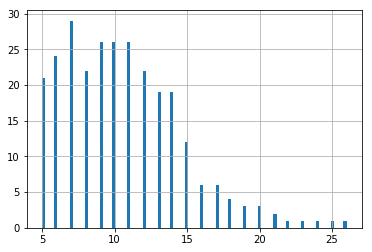

In [485]:
test_b = shape_for_scatter_plot(b250)
error=0.025
test_b[test_b.bstd <= error].radius.hist(bins=100)

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


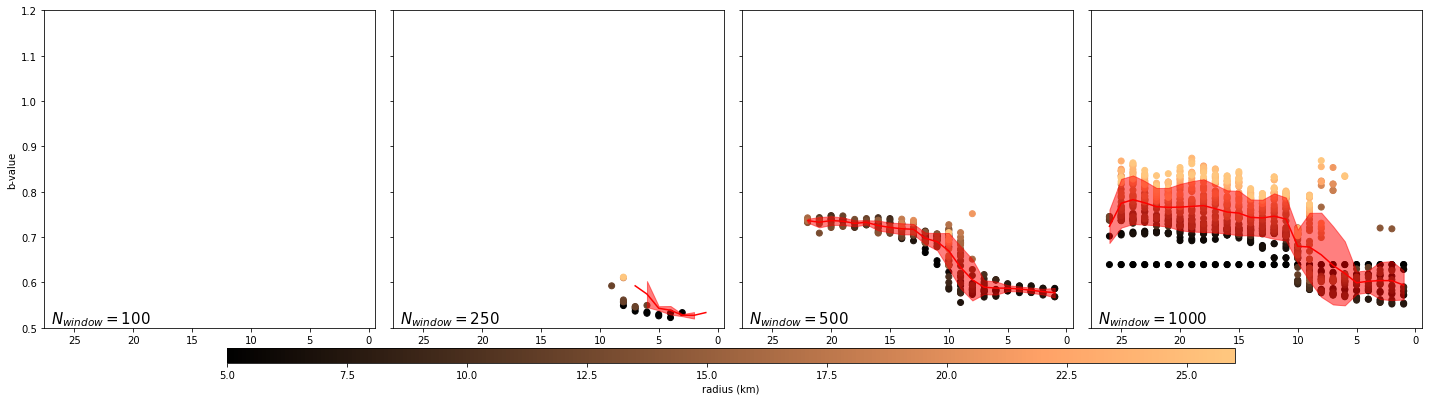

In [486]:
fig, (ax,ax3,ax4,ax5) = plt.subplots(1, 4, figsize=(20,5), sharex=True, sharey='all')



def plotbdf(bdf,fig, ax, remove_below_error=False, error=0.025):
    test_b = shape_for_scatter_plot(bdf)
    if remove_below_error == True:
        test_b = test_b[test_b.bstd <= error].copy()
    plot_scatter_plot(test_b, x='years before', y='b', c='radius'
                      , cmap='copper', ax=ax, label=None)
    plot_fill_between(test_b, x='years before', y='b', color='red'
                      , ax=ax)
#     ax2 = ax.twinx()
#     plot_fill_between(test_b, x='years before', y='bstd', color='black'
#                       , ax=ax2)
#     ax2.plot([0, 27], [0.05, 0.05], linestyle='--', color='black') 
#     ax2.set_ylim(0.0, 0.1)
#     


plotbdf(b50, fig, ax, remove_below_error=True)
plotbdf(b125, fig, ax3, remove_below_error=True)
plotbdf(b250, fig, ax4, remove_below_error=True)
plotbdf(b500, fig, ax5, remove_below_error=True)

ax.set_ylim(0.5, 1.2)
ax.set_ylabel('b-value')



ax2.set_ylim(0.0, 0.1)
ax2.set_xlim(0.0, 27)
ax2.set_ylabel('b-error')


ax.text(s='$N_{window}=100$', x=27, y=0.51, fontsize=15)
ax3.text(s='$N_{window}=250$', x=27, y=0.51, fontsize=15)
ax4.text(s='$N_{window}=500$', x=27, y=0.51, fontsize=15)
ax5.text(s='$N_{window}=1000$', x=27, y=0.51, fontsize=15)

ax5 = fig.add_axes([0.16, -0.02, 0.7, .04])
cmap = mpl.cm.copper
norm = mpl.colors.Normalize(vmin=5, vmax=26)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('radius (km)')


ax.invert_xaxis()
plt.tight_layout()

fig.savefig('paper_plots/b_over_t_scatter_fill.pdf', bbox_inches='tight')

In [417]:
mpl.cm.copper(0.5)

(0.62006905825364722, 0.39213176470588235, 0.24972549019607843, 1.0)

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=130.31303194773173,32.30453194773171,131.21296805226828,33.20446805226829&bboxSR=4269&imageSR=4269&size=1500,1500&dpi=96&format=png32&f=image


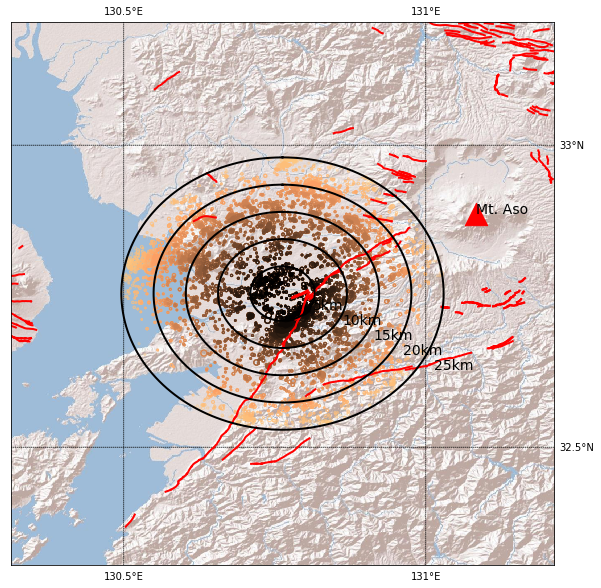

In [507]:
fig, ax = plt.subplots(figsize=(10, 10))
norm = mpl.colors.Normalize(vmin=5, vmax=25)


dist_in_deg = 50./111.119

m = Basemap(projection='merc'
            ,llcrnrlon=lon-dist_in_deg
            ,llcrnrlat=lat-dist_in_deg
            ,urcrnrlon=lon+dist_in_deg
            ,urcrnrlat=lat+dist_in_deg
            , epsg=4269
            , ax=ax
            , resolution='i'
            , area_thresh=1)

lines = np.arange(0, 180, 0.5)
m.drawparallels(lines, labels=lines)
m.drawmeridians(lines, labels=lines)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1500, verbose= True
             ,zorder=0)


# PLOT FAULT LINES
for fault in fault_coordinates:
    x, y = m(fault[:,0], fault[:,1])
    ax.plot(x, y, color='red', linewidth=2)

r = 5
for r in np.arange(5, 26, 1)[::-1]:
    eqs = polygon_selection.get_node_data(node=eq['coordinates'],data=df_regional
                                          , radius=r, m=1)
    eqs = eqs[eqs.mag >= 1]

    x, y = m(eqs['lon'].values, eqs['lat'].values)

    ax.scatter(x, y, edgecolors=mpl.cm.copper(norm(r)), alpha=0.5, color='None'
              ,s=np.exp(eqs['mag'].values), rasterized=True)
    
x, y = m(131.0841, 32.8869)
ax.text(s='Mt. Aso', x=x, y=y, fontsize=14, zorder=5)

# x, y = m(131.0841, 32.8869)
ax.scatter(x, y, marker='^', s=500, color='red')

x, y = m(eq['coordinates'][0], eq['coordinates'][1])
# ax.scatter(x, y, s=np.exp(7.3), edgecolors='yellow', color='None', linewidth=3)
# ax.text(s='M7.3', x=x+.05, y=y, color='yellow', fontsize=20, zorder=5)
# plot_beach_ball(earthquake=eq, m=m, ax=ax, width=0.05, alpha=0.95)

r = 5
for r in np.arange(5, 26, 5):
    plotting.equi(m, eq['coordinates'][0], eq['coordinates'][1]
                  , r, color='black', linewidth=2)
    ax.text(s='{r}km'.format(r=r), x=x+(r)/100., y=y-(r*0.5)/100., fontsize=14
           ,color='black')

fig.savefig('paper_plots/b_over_t_seismicity.pdf', bbox_inches='tight')

In [ ]:


true_bdf = b125
true_bdf = true_bdf[true_bdf.n >= 50].copy()
true_bdf['years before'] = true_bdf['start_time'].values.astype('datetime64[Y]').astype(int) - 20

fig, ax = plt.subplots(figsize=(10, 7))


cbar = ax.scatter(x=true_bdf['years before'], y=true_bdf['b']
                  , c=true_bdf['radius']
                 ,cmap='copper')

cbar = fig.colorbar(cbar, shrink=0.99, pad = 0.0751, label='radius (km)'
                   , ticks=[np.arange(5, 31, 2)])
cbar.ax.set_yticklabels(np.arange(5, 31, 2).astype(int))  # vertically oriented colorbar


x = np.arange(0, 27, 1)[1:]

ax.set_xticks(x)
ax.set_xticklabels(x[::-1])

avg = true_bdf.groupby('years before').b.mean()
std = true_bdf.groupby('years before').b.std()

ax.fill_between(x, avg-std, avg+std, alpha=0.25, color='red')
ax.plot(x, avg, color='red', linewidth=4)

ax.set_ylim(0.5, 1.0)
ax.set_ylabel('b-value')
ax.set_xlabel('years before mainshock')

ax2 = ax.twinx()

ax2.plot(x, true_bdf.groupby('years before').bstd.mean(), color='black', linewidth=3)

avg =  true_bdf.groupby('years before').bstd.mean()
std =  true_bdf.groupby('years before').bstd.std()

ax2.fill_between(x, avg-std, avg+std, color='black', alpha=0.25)
ax2.set_ylim(0, 0.1)
x2 = np.arange(-1, 28, 1)
ax2.plot(x2, (0.05,)*len(x2), linestyle='--', color='black')
ax2.set_xlim(-1, 27)
ax2.set_ylabel('b-error')

ax2.set_yticks(np.arange(0, 0.11, 0.01))
plt.tight_layout()




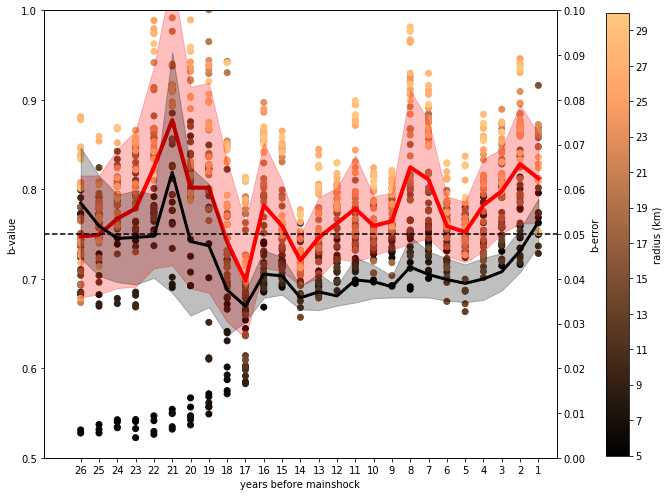

In [307]:
true_bdf = b125
true_bdf = true_bdf[true_bdf.n >= 50].copy()
true_bdf['years before'] = true_bdf['start_time'].values.astype('datetime64[Y]').astype(int) - 20

fig, ax = plt.subplots(figsize=(10, 7))


cbar = ax.scatter(x=true_bdf['years before'], y=true_bdf['b']
                  , c=true_bdf['radius']
                 ,cmap='copper')

cbar = fig.colorbar(cbar, shrink=0.99, pad = 0.0751, label='radius (km)'
                   , ticks=[np.arange(5, 31, 2)])
cbar.ax.set_yticklabels(np.arange(5, 31, 2).astype(int))  # vertically oriented colorbar


x = np.arange(0, 27, 1)[1:]

ax.set_xticks(x)
ax.set_xticklabels(x[::-1])

avg = true_bdf.groupby('years before').b.mean()
std = true_bdf.groupby('years before').b.std()

ax.fill_between(x, avg-std, avg+std, alpha=0.25, color='red')
ax.plot(x, avg, color='red', linewidth=4)

ax.set_ylim(0.5, 1.0)
ax.set_ylabel('b-value')
ax.set_xlabel('years before mainshock')

ax2 = ax.twinx()

ax2.plot(x, true_bdf.groupby('years before').bstd.mean(), color='black', linewidth=3)

avg =  true_bdf.groupby('years before').bstd.mean()
std =  true_bdf.groupby('years before').bstd.std()

ax2.fill_between(x, avg-std, avg+std, color='black', alpha=0.25)
ax2.set_ylim(0, 0.1)
x2 = np.arange(-1, 28, 1)
ax2.plot(x2, (0.05,)*len(x2), linestyle='--', color='black')
ax2.set_xlim(-1, 27)
ax2.set_ylabel('b-error')

ax2.set_yticks(np.arange(0, 0.11, 0.01))
plt.tight_layout()




In [295]:
avg.shape

(26,)

In [297]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

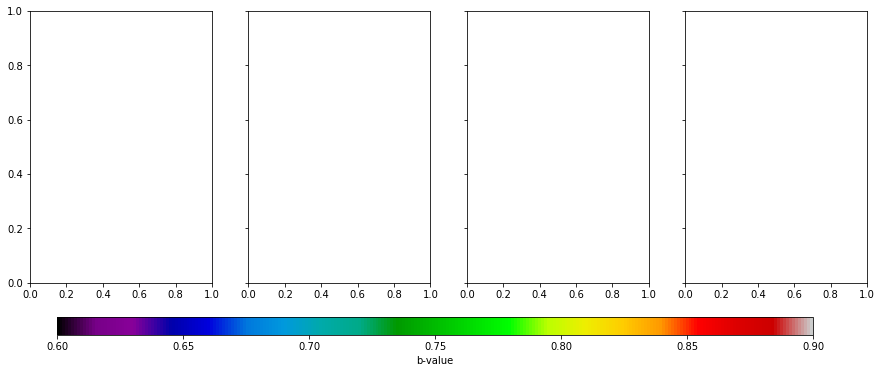

In [266]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5), sharey=True)
ax5 = fig.add_axes([0.15, -0.02, 0.7, .05])
cmap = mpl.cm.nipy_spectral
norm = mpl.colors.Normalize(vmin=0.6, vmax=0.9)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax5, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('b-value')

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


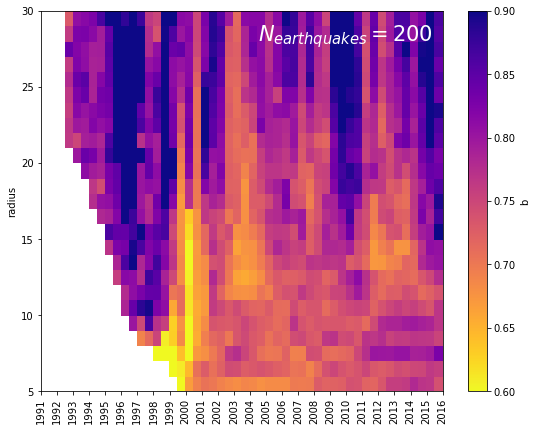

In [197]:
fig, ax = plt.subplots(figsize=(9,7))

half_window_size = 100
b_over_t = []
for r in radii:
    b_over_t.append(calc_b_over_t_df(df=df_regional
                    , time_window_centers=time_window_centers
                     ,half_window_size=half_window_size, radius=r))
bt_df = pd.concat(b_over_t)
plotting.plot_radius_time_sweep(dataframe=bt_df, vertical_axis='radius'
                                , value='b', fig=fig, ax=ax, cmap='plasma_r'
                               ,vmin=0.6, vmax=0.9)
ax.text(s='$N_{earthquakes}=$'+'{n}'.format(n=half_window_size*2), x=27, y=28, fontsize=21, color='white')

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


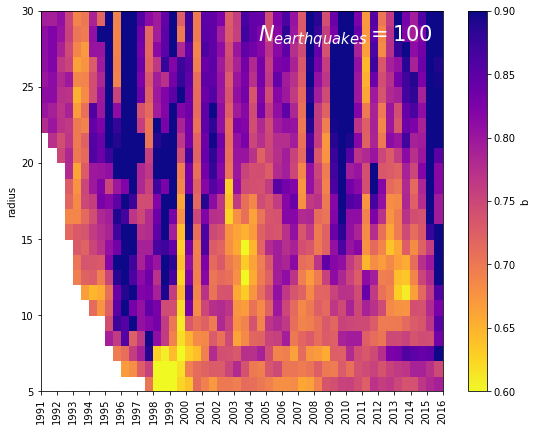

In [198]:
half_window_size = 50

b_over_t = []
for r in radii:
    b_over_t.append(calc_b_over_t_df(df=df_regional
                    , time_window_centers=time_window_centers
                     ,half_window_size=half_window_size, radius=r))

bt_df = pd.concat(b_over_t)


fig, ax = plt.subplots(figsize=(9,7))

plotting.plot_radius_time_sweep(dataframe=bt_df, vertical_axis='radius'
                                , value='b', fig=fig, ax=ax, cmap='plasma_r'
                               ,vmin=0.6, vmax=0.9)

ax.text(s='$N_{earthquakes}=$'+'{n}'.format(n=half_window_size*2)
        , x=27, y=28, fontsize=21, color='white')

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


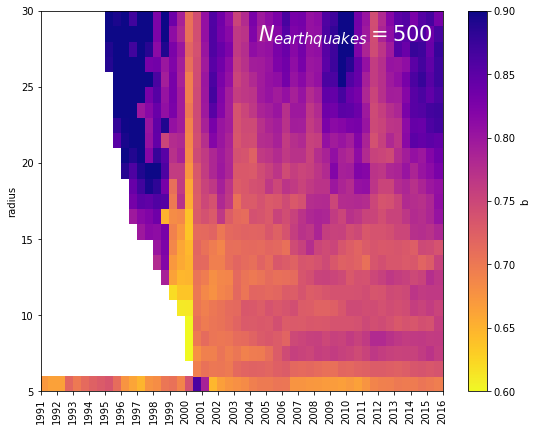

In [199]:
half_window_size = 250

b_over_t = []
for r in radii:
    b_over_t.append(calc_b_over_t_df(df=df_regional
                    , time_window_centers=time_window_centers
                     ,half_window_size=half_window_size, radius=r))

bt_df = pd.concat(b_over_t)


fig, ax = plt.subplots(figsize=(9,7))

plotting.plot_radius_time_sweep(dataframe=bt_df, vertical_axis='radius'
                                , value='b', fig=fig, ax=ax, cmap='plasma_r'
                               ,vmin=0.6, vmax=0.9)

ax.text(s='$N_{earthquakes}=$'+'{n}'.format(n=half_window_size*2)
        , x=27, y=28, fontsize=21, color='white')

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


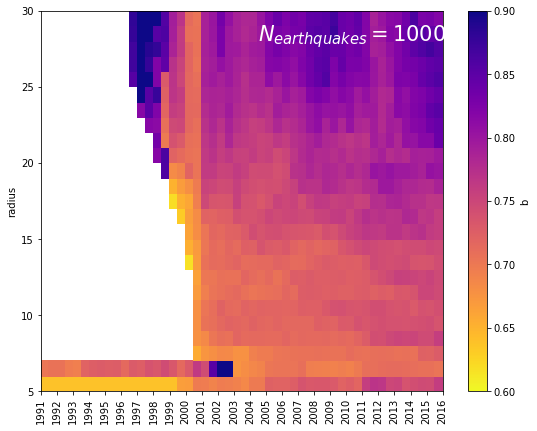

In [200]:
half_window_size = 500

b_over_t = []
for r in radii:
    b_over_t.append(calc_b_over_t_df(df=df_regional
                    , time_window_centers=time_window_centers
                     ,half_window_size=half_window_size, radius=r))

bt_df = pd.concat(b_over_t)


fig, ax = plt.subplots(figsize=(9,7))

plotting.plot_radius_time_sweep(dataframe=bt_df, vertical_axis='radius'
                                , value='b', fig=fig, ax=ax, cmap='plasma_r'
                               ,vmin=0.6, vmax=0.9)

ax.text(s='$N_{earthquakes}=$'+'{n}'.format(n=half_window_size*2)
        , x=27, y=28, fontsize=21, color='white')

In [53]:
def plot_time_window_b_value(df, fig, ax, time_window_centers
                             , color, half_window_size, radius, **kwargs):
    df = df[df.distance <= radius].copy()
    b_over_time = []
    
    for t in time_window_centers:
        row = (t,) + calc_b_with_time_window(df, n_eq=half_window_size*2
                                            ,time_window_center=t)
        b_over_time.append(row)
        
    bdf = pd.DataFrame(b_over_time, columns=['time', 'a', 'b', 'bstd', 'n', 'mc', 't_index'])
    bdf = bdf.set_index(bdf['time'])
    
    ax.errorbar(x=time_window_centers, y=bdf.b, yerr=bdf.bstd
               , fmt='o', color=color, marker='', **kwargs)
    for y, t in zip(bdf.b.values, time_window_centers):
        try:
            tix = df.index.get_loc(t, method='pad')
            lower_ix = tix - half_window_size
            if lower_ix < 0:
                lower_ix = 0
            lower_t = df.ix[lower_ix].name
            upper_t = df.ix[tix + half_window_size].name
            ax.plot_date(x=[lower_t, upper_t], y=(y, y), linewidth=2
                        ,marker='None', linestyle='-', color=color
                        ,**kwargs)
        except IndexError:
            pass

In [6]:
time_window_centers = pd.date_range('01-01-1991', eq['time'], freq='6m')

# b_over_time = []

# r = 5
# half_window_size = 50
# df_local = df_regional[df_regional.distance <= r].copy()

# for t in time_window_centers:
#     row = (t,) + calc_b_with_time_window(dataframe=df_local, n_eq=half_window_size*2, time_window_center=t)
#     b_over_time.append(row)
    
# b_over_time = np.array(b_over_time)
# bt_df = pd.DataFrame(b_over_time, columns=['time', 'a', 'b', 'bstd', 'n', 'mc', 't_index'])

# bt_df = bt_df.set_index(bt_df['time'])

In [7]:
df_local.shape

NameError: name 'df_local' is not defined

/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


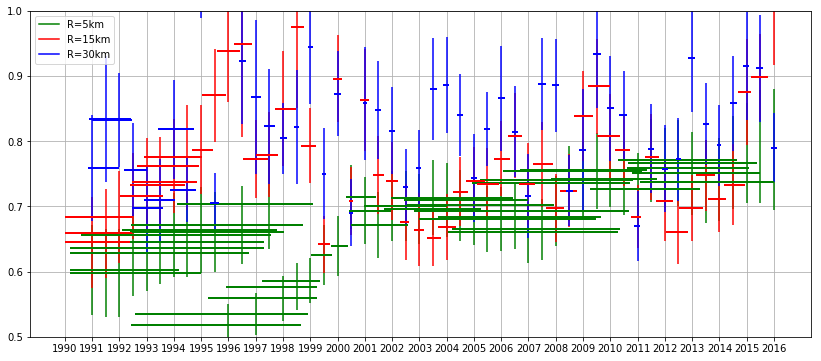

In [463]:
fig, ax = plt.subplots(figsize=(14, 6))
plot_time_window_b_value(df_regional, fig, ax, time_window_centers
                        ,color='green', half_window_size=50, radius=5, label=None)
plot_time_window_b_value(df_regional, fig, ax, time_window_centers
                        ,color='red', half_window_size=50, radius=15, label=None)
plot_time_window_b_value(df_regional, fig, ax, time_window_centers
                        ,color='blue', half_window_size=50, radius=30, label=None)

ax.grid(True)
ax.set_xticks(pd.date_range('01-01-1990', eq['time'], freq='12m'))
ax.set_ylim(0.5, 1.)

ax.plot([], [], color='green', label='R=5km')
ax.plot([], [], color='red', label='R=15km')
ax.plot([], [], color='blue', label='R=30km')

ax.legend()

fig.savefig('paper_plots/b_over_t_multiple.pdf', bbox_inches='tight')

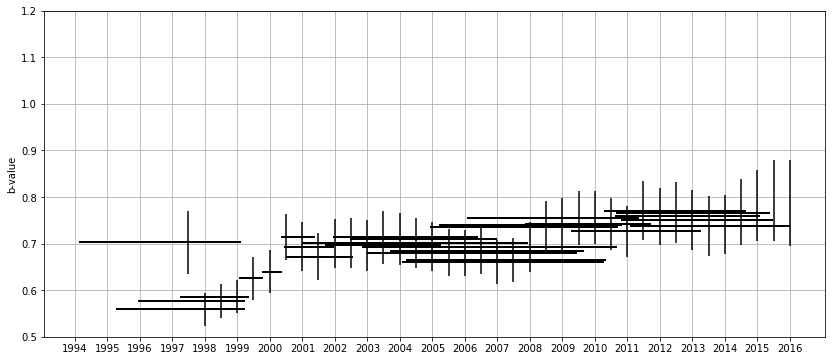

In [114]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.errorbar(x=time_window_centers, y=bt_df.b, yerr=bt_df.bstd
            , fmt='o', color='black', marker='')

ax.set_ylabel('b-value')
ax.set_ylim(0.5, 1.2)

ax.set_xticks(pd.date_range('01-01-1990', eq['time'], freq='12m'))


mc_y = []
mc_x = []

#########################
# PLOT time window horizontal bar
for mc, y, t in zip(bt_df.mc.values, bt_df.b.values, time_window_centers):
    try:
        tix = df_local.index.get_loc(t, method='pad')
        lower_ix = tix - half_window_size
        if lower_ix < 0:
            lower_ix = 0
        
        lower_t = df_local.ix[lower_ix].name
        upper_t = df_local.ix[tix + half_window_size].name
        middle_t = df_local.ix[tix].name
        
        ax.plot_date(x=[lower_t, upper_t], y=(y, y), linewidth=2, marker='None', linestyle='-'
                    ,color='black')
        
        mc_y.append(mc)
        mc_x.append(middle_t)
    except IndexError:
        pass

ax.grid(True)


/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


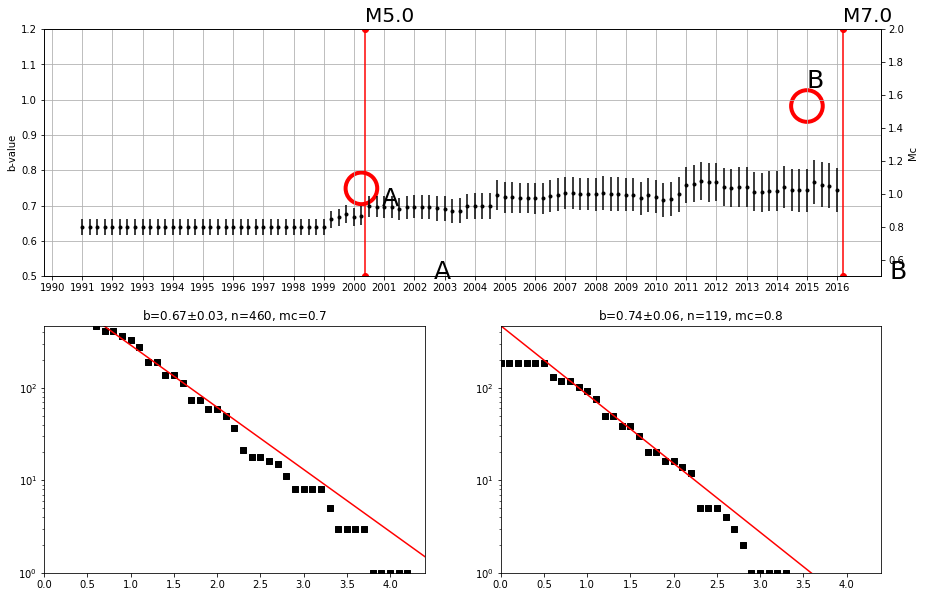

In [55]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), rowspan=1, sharex=ax3, sharey=ax3)



ax.errorbar(x=time_window_centers, y=bt_df.b, yerr=bt_df.bstd
            , fmt='o', color='black', marker='.')

ax.set_ylabel('b-value')
ax.set_ylim(0.5, 1.2)

ax.set_xticks(pd.date_range('01-01-1990', eq['time'], freq='12m'))

# ax.scatter(x=pd.to_datetime('06-13-1997'), y=0.65, marker='*', s=150)

mc_y = []
mc_x = []

#########################
# PLOT time window horizontal bar
for mc, y, t in zip(bt_df.mc.values, bt_df.b.values, time_window_centers):
    try:
        tix = df_local.index.get_loc(t, method='pad')
        lower_t = df_local.ix[tix - 1000].name
        upper_t = df_local.ix[tix + 1000].name
        middle_t = df_local.ix[tix].name
        
        ax.plot_date(x=[lower_t, upper_t], y=(y, y), linewidth=2, marker='None', linestyle='-'
                    ,color='black')
        
        mc_y.append(mc)
        mc_x.append(middle_t)
    except IndexError:
        pass

ax.grid(True)

x = pd.to_datetime(['2000-06-08 00:32:46.129979', '2000-06-08 00:32:46.129979'])

ax.plot_date(x, y=[0.5, 1.2], linestyle='-', color='red')
ax.text(s='M5.0', x=x[0], y= 1.22, fontsize=20)

ax.plot_date(x=[upper_t, upper_t], y=(0.5, 1.2), linestyle='-', color='red')
ax.text(s='M7.0', x=upper_t, y=1.22, fontsize=20)

ax2 = ax.twinx()

ax2.plot_date(mc_x, mc_y, linestyle='--', color='green', marker='', linewidth=3
             , zorder=0)
ax2.set_ylabel('Mc')
ax2.set_ylim(0.5, 2.0)

bt_min = ('2000-04-30', 0.749104)
bt_max = ('2015-01-31', 0.982399)

###########################
# minimum b-value
x = pd.to_datetime('2000-04-30')
tix = df_local.index.get_loc(x, method='pad')
mags = df_local.ix[tix-1000 : tix+1000]

ax.scatter(x, y=bt_min[1], marker='o', s=1000, edgecolor='Red', color='None', zorder=0
          ,linewidth=4)
ax.text(s='A', x='2001-01-01', y=bt_min[1]-0.05, fontsize=25)
plotting.plot_fmd_diagram(mags, fig, ax3)
ax3.text(s='A', x=4.5, y=1.5e3, fontsize=25)


##########################
# maximum b-value
x = pd.to_datetime('2015-01-31')
tix = df_local.index.get_loc(x, method='pad')
mags = df_local.ix[tix-1000 : tix+1000]

ax.scatter(x, y=bt_max[1], marker='o', s=1000, edgecolor='Red', color='None', zorder=0
          ,linewidth=4)
ax.text(s='B', x=x, y=bt_max[1]+0.05, fontsize=25)
plotting.plot_fmd_diagram(mags, fig, ax4)
ax4.text(s='B', x=4.5, y=1.5e3, fontsize=25)


# fig.savefig('paper_plots/b_over_t.pdf', bbox_inches='tight')